In [1]:
#pip
!pip install torchvision

In [28]:
#imports
import pandas as pd
import os
import numpy as np
from numpy.distutils.misc_util import is_sequence
from bs4 import BeautifulSoup #this is to extract info from the xml, if we use it in the end
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import json
import pickle

import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler 
from sklearn.metrics import f1_score, precision_score, recall_score
import statistics 



In [29]:
batch_size = 8
num_epochs = 1

In [30]:
# Get label and encode
def get_box(obj):
    xmin = float(obj.find('xmin').text)
    xmax = float(obj.find('xmax').text)
    ymin = float(obj.find('ymin').text)
    ymax = float(obj.find('ymax').text)
    return [xmin, ymin, xmax, ymax]

def get_label(obj):
    if obj.find('name').text == 'person' or obj.find('name').text == 'people':
        return 1
    if obj.find('name').text == 'cyclist':
        return 2
    else:
        return 0

# Generate the target location in the image
def generate_target(image_id,file):
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml') #probably will have to change this
        objects = soup.find_all('object')

        num_objs = len(objects)

        boxes = []
        labels = []

        for i in objects:
            boxes.append(get_box(i))
            labels.append(get_label(i))
            
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        img_id = torch.tensor([image_id])

        # Creating the target for the box
        target={}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = img_id

        return target

def OHE(label):
  if label == "People" or label== "Person":
      return 1
  elif label == "Cyclist":
      return 2
  else:
      return 0

def Recode(label):
  if label == 1:
      return "Person(s)"
  elif label == 2:
      return "Cyclist"
  else:
      return "N/A"

class FullImages(object):
    def __init__(self, transforms=None):
        self.csv = pd.read_csv("frame_MasterList.csv").head(25)  # will always grab this
        self.csv_len = self.csv.shape[1]
        self.imgs = self.csv.image_path.tolist()
        self.imgs_len = len(self.imgs)
        self.transforms = transforms

    def __len__(self):
        #return int(self.imgs_len/150)
        return self.imgs_len
        print(f'Length of images {self.imgs_len}')
        #return self.csv_len

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img = self.csv.loc[idx, 'image_path']
        annotation = self.csv.loc[idx, 'annotation_path']

        img = Image.open(img).convert("L")
        target = generate_target(idx, annotation)

        # label = self.labels[idx]
        # label = OHE(label)
        # label = torch.as_tensor(label, dtype=torch.int64)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target


In [31]:
# Normalize
data_transform = transforms.Compose([#transforms.Resize((80,50)),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.5], [0.5]
                                                          )])

# Collate images
def collate_fn(batch):
    return tuple(zip(*batch)) #will need adjusting when pathing is adjusted

dataset = FullImages(data_transform)
data_size = len(dataset)
print(f'Length of Dataset: {data_size}')

indices = list(range(data_size))
test_split = 0.2
split = int(np.floor(test_split * data_size))
#print(f'Length of Split Dataset: {split}')

train_indices, test_indices = indices[split:], indices[:split]
len_train_ind, len_test_ind = len(train_indices), len(test_indices)
print(f'Length of Train: {len_train_ind}; Length of Test: {len_test_ind}')


Length of Dataset: 25
Length of Train: 20; Length of Test: 5


In [32]:

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size = batch_size,
    sampler = train_sampler,
    collate_fn = collate_fn
)
len_dataloader = len(data_loader)
print(f'Length of train: {len_dataloader}')

data_loader_test = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler = test_sampler, collate_fn = collate_fn)
len_testdataloader = len(data_loader_test)
print(f'Length of test: {len_testdataloader}')


Length of train: 3
Length of test: 1


In [19]:
train_i = 0
tot_ats = 0
train_ids = []
#print("Train")
for imgs, annotations in data_loader:
    train_i += 1
    imgs_train = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    ats = len([annotations[0]][0].get("labels"))
    train_ids.append([annotations[0]][0].get("image_id").item()) 
    #print(f'Annotations in image {train_i} in train data loader: {ats}')
    tot_ats += ats

#print("Test")
test_i = 0
test_tot_ats = 0
test_ids = []
for test_imgs, test_annotations in data_loader_test:
    test_i += 1
    imgs_test = list(img_test.to(device) for img_test in test_imgs)
    annotations_test = [{k: v.to(device) for k, v in t.items()} for t in test_annotations]
    test_ats = len([annotations_test[0]][0].get("labels"))
    test_ids.append([annotations_test[0]][0].get("image_id").item()) 
    #print(f'Annotations in image {test_i} in train data loader: {test_ats}')
    test_tot_ats += test_ats
    

print(f'Images ids for the {train_i} images in train data loader: {train_ids} totalling {tot_ats} '
      f'annotations.')
print(f'Images ids for the {test_i} images in test data loader: {test_ids} totalling {test_tot_ats} annotations.')

Images ids for the 3 images in train data loader: [18, 12, 7] totalling 9 annotations.
Images ids for the 1 images in test data loader: [0] totalling 3 annotations.


In [33]:
# Check if GPU
cuda = torch.cuda.is_available()
if cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Instance segmentation is crucial in using the full images
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(
        in_features, num_classes)
    return model


In [34]:
#cnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = False)
model = get_model_instance_segmentation(3)
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params) #, lr = 0.005, weight_decay = 0.0005)

# Learning rate scheduler
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
#                                                step_size = 5,
#                                                gamma = 0.2)

In [35]:
tot_ats = 0
epochs = 0
epoch_ats = []
epoch_losses = []
df = pd.DataFrame({'Mean_Epoch_Loss': epoch_losses}) 
for epoch in range(num_epochs):
    epochs += 1
    #print(f'Epoch: {epochs}')
    model.train()
    epoch_loss = 0
    i = 0
    for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        i += 1
        tot_ats += 1 
    
        epoch_loss += losses
        print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
    
    mean_epoch_loss = epoch_loss/i
    epoch_losses.append(mean_epoch_loss)
    epoch_ats.append(i)
    
    if epochs % 20 == 0:
        df = pd.DataFrame({'Mean_Epoch_Loss': epoch_losses})  
        print(df)
        partial_name = "full_model_partial_" + str(epochs)     
        df.to_csv(partial_name+ "_losses.csv"   , index=False)
        torch.save(model.state_dict(), partial_name + ".pt") 
        
    # Update learning rate
    #lr_scheduler.step()

# Save model
# torch.save(model.state_dict(), 'full_model.pt')

# Save training metrics
# full_name = "full_model_losses_full_" + str(epochs) + ".csv"
# df.to_csv(full_name, index=False)
# with open('epoch_losses_list', 'wb') as lossFile:
#     pickle.dump(epoch_losses, lossFile)

print(f'Annotations Trained: {tot_ats}')


Iteration: 1/3, Loss: 1.1726235151290894


Iteration: 2/3, Loss: 3.385636806488037


Iteration: 3/3, Loss: 134.59429931640625
Annotations Trained: 3


In [11]:
# model2 = get_model_instance_segmentation(3)
#model2.load_state_dict(torch.load('model.pt'))
#model2.eval()
#model2.to(device)


In [36]:
def plot_images(num, input):
    fig, ax = plt.subplots(nrows=1, ncols=2)
    img_tensor = imgs[num]
    annotation = annotations[num]
    # for key, value in annotation.items():
    #         print(key, value)
    prediction = preds[num]
    
    img = img_tensor.cpu().data
    img = img[0,:,:]
    
    ax[0].imshow(img, cmap='gray')
    ax[1].imshow(img, cmap='gray')
    
    ix = 0
    for box in annotation["boxes"]:
        #print(annotations[ix])
        xmin, ymin, xmax, ymax = box.tolist()
        value = annotation["labels"][ix]
        img_id = annotation["image_id"].item()
        file_name = master_csv.loc[img_id,:].image_path
        set = file_name.split("/")[7]
        video = file_name.split("/")[8]
        file_name = file_name.split("/")[10]
        file_name = file_name[:-4]
        output_name = set+"_"+video+"_"+file_name
        text = Recode(value)
        colors = ["r", "#00FF00",  "#0000FF"]
        rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=1,
                                 edgecolor=colors[value], facecolor='none')
        target_x = xmin
        target_y = ymin - 5
        ax[0].text(target_x, target_y, text, color=colors[value])
        ax[0].add_patch(rect)
        ix += 1
        

    ix = 0
    print(str(len(prediction["boxes"])) + " prediction boxes made for " + str(len(annotation["boxes"])) + " actual boxes in " + str(output_name))
    for box in prediction["boxes"]:
        xmin, ymin, xmax, ymax = box.tolist()
        value = prediction["labels"][ix]
        text = Recode(value)
        colors = ["r", "#00FF00",  "#0000FF"]
        rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=1,
                                 edgecolor=colors[value], facecolor='none')
        target_x = xmin
        target_y = ymin - 5
        ax[1].text(target_x, target_y, text, color=colors[value])
        ax[1].add_patch(rect)
        ix += 1
        
    #figname = file_name+"_"+input+".png"
    #fig.savefig(figname)
    plt.show()


In [26]:
# A predicted bounding box is considered correct if it overlaps more than 50% with a ground-truth bounding box, otherwise the bounding box is considered a false positive detection. Multiple detections are penalized. If a system predicts several bounding boxes that overlap with a single ground-truth bounding box, only one prediction is considered correct, the others are considered false positives.

### TO DO
# Dictionary like {cyclist: [IOU, IOU, IOU], people: [IOU, IOU]}
# Use get_iou to store set, video, frame, annotation boxes, pred boxes, lists of iou
# Call get iou on all data and export results

def plot_iou(num: object, input: object, test: object = False) -> object:
    fig, ax = plt.subplots(1)
    if test:
        print("Test")
        img_tensor = imgs_test[num]
        #print(img_tensor)
        annotation = annotations_test[num] 
        #print(annotation)
    else:   
        print("Train")
        img_tensor = imgs[num]
        #print(img_tensor)
        annotation = annotations[num]
        #print(annotation)
    # for key, value in annotation.items():
    #         print(key, value)
    prediction = preds[num]
    
    img = img_tensor.cpu().data
    img = img[0,:,:]
    
    ax.imshow(img, cmap='gray')
    
    #print("Annotations")
    annotation_boxes = annotation["boxes"].tolist()
    #print(annotation_boxes)
    
    ix = 0
    for box in annotation["boxes"]:
        #print(annotations[ix])
        xmin, ymin, xmax, ymax = box.tolist()
        value = annotation["labels"][ix]
        img_id = annotation["image_id"].item()
        file_name = master_csv.loc[img_id,:].image_path
        set = file_name.split("/")[7]
        video = file_name.split("/")[8]
        file_name = file_name.split("/")[10]
        file_name = file_name[:-4]
        output_name = set+"_"+video+"_"+file_name
        text = Recode(value)
        colors = ["r", "r", "r"]
        rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=1,
                                 edgecolor=colors[value], facecolor='none')
        target_x = xmin
        target_y = ymin - 5
        ax.text(target_x, target_y, text, color=colors[value])
        ax.add_patch(rect)
        ix += 1  

    ix = 0
    voc_iou = []
    print(str(len(prediction["boxes"])) + " prediction boxes made for " + str(len(annotation["boxes"])) + " actual boxes in " + str(output_name))
    for box in prediction["boxes"]:
        xmin, ymin, xmax, ymax = box.tolist()
        
        iou_list = []
        for bound in annotation_boxes:
            a_xmin, a_ymin, a_xmax, a_ymax = bound
            xA = max(xmin, a_xmin)
            yA = max(ymin, a_ymin)
            xB = min(xmax, a_xmax)
            yB = min(ymax, a_ymax)
            interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
            p_area = (xmax - xmin + 1) * (ymax - ymin + 1)
            a_area = (a_xmax - a_xmin + 1) * (a_ymax - a_ymin + 1)
            iou = interArea / float(p_area + a_area - interArea)
            iou_list.append(iou)
        max_val = max(iou_list) 
        voc_iou.append(max_val)

        max_ix = iou_list.index(max_val)
        map_dict = {max_ix: max_val} 
        
        #iou_string = ', '.join((str(float) for float in iou_list))
        value = prediction["labels"][ix]
        text = json.dumps(map_dict)
        colors = ["r", "#00FF00",  "#0000FF"]
        rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=1,
                                 edgecolor=colors[value], facecolor='none')
        target_x = xmin
        target_y = ymin - 5
        ax.text(target_x, target_y, text, color=colors[value])
        ax.add_patch(rect)
        ix += 1
    
    plt.show()
    
    mean_iou = sum(voc_iou)/len(voc_iou)
    fp = voc_iou.count(0)/len(voc_iou) * 100
    bp = sum((i > 0 and i < 0.5) for i in voc_iou)/len(voc_iou) * 100
    gp = sum((i >= 0.5) for i in voc_iou)/len(voc_iou) * 100
    print(f'{fp} false positives (IOU = 0)') 
    print(f'{bp} bad positives (0 < IOU < 0.5)')
    print(f'{gp} good positives (IOU >= 0.5)')
    print(f'Mean: {mean_iou}')

#figname = file_name+"_"+input+".png"
#fig.savefig(figname)


In [37]:
# A predicted bounding box is considered correct if it overlaps more than 50% with a ground-truth bounding box, otherwise the bounding box is considered a false positive detection. Multiple detections are penalized. If a system predicts several bounding boxes that overlap with a single ground-truth bounding box, only one prediction is considered correct, the others are considered false positives.

def get_iou(num, input):
    if test:
        print("Test")
        img_tensor = imgs_test[num]
        print(img_tensor)
        annotation = annotations_test[num] 
        print(annotation)
    else:   
        print("Train")
        img_tensor = imgs[num]
        print(img_tensor)
        annotation = annotations[num]
        print(annotation)
    # for key, value in annotation.items():
    #         print(key, value)
    prediction = preds[num]
    
    img = img_tensor.cpu().data
    img = img[0,:,:]
    
    #print("Annotations")
    annotation_boxes = annotation["boxes"].tolist()
    #print(annotation_boxes)
    
    ix = 0
    for box in annotation["boxes"]:
        xmin, ymin, xmax, ymax = box.tolist()
        value = annotation["labels"][ix]
        img_id = annotation["image_id"].item()
        file_name = master_csv.loc[img_id,:].image_path
        set = file_name.split("/")[7]
        video = file_name.split("/")[8]
        file_name = file_name.split("/")[10]
        file_name = file_name[:-4]
        output_name = set+"_"+video+"_"+file_name
        colors = ["r", "r", "r"]
        ix += 1  

    ix = 0
    voc_iou = []
    print(str(len(prediction["boxes"])) + " prediction boxes made for " + str(len(annotation["boxes"])) + " actual boxes in " + str(output_name))
    for box in prediction["boxes"]:
        xmin, ymin, xmax, ymax = box.tolist()
        
        iou_list = []
        for bound in annotation_boxes:
            a_xmin, a_ymin, a_xmax, a_ymax = bound
            xA = max(xmin, a_xmin)
            yA = max(ymin, a_ymin)
            xB = min(xmax, a_xmax)
            yB = min(ymax, a_ymax)
            interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
            p_area = (xmax - xmin + 1) * (ymax - ymin + 1)
            a_area = (a_xmax - a_xmin + 1) * (a_ymax - a_ymin + 1)
            iou = interArea / float(p_area + a_area - interArea)
            iou_list.append(iou)
        max_val = max(iou_list) 
        voc_iou.append(max_val)

        max_ix = iou_list.index(max_val)
        map_dict = {max_ix: max_val} 
        
        #iou_string = ', '.join((str(float) for float in iou_list))
        value = prediction["labels"][ix]
        text = json.dumps(map_dict)
        ix += 1
    
    mean_iou = sum(voc_iou)/len(voc_iou)
    fp = voc_iou.count(0)/len(voc_iou) * 100
    bp = sum((i > 0 and i < 0.5) for i in voc_iou)/len(voc_iou) * 100
    gp = sum((i >= 0.5) for i in voc_iou)/len(voc_iou) * 100
    print(f'{fp} false positives (IOU = 0)') 
    print(f'{bp} bad positives (0 < IOU < 0.5)')
    print(f'{gp} good positives (IOU >= 0.5)')
    print(f'Mean: {mean_iou}')

#figname = file_name+"_"+input+".png"
#fig.savefig(figname)

 


 


In [39]:
def plot_image_og(img_tensor, annotation):
    fig, ax = plt.subplots(1)
    img = img_tensor.cpu().data
    height, width = img_tensor.size()[1], img_tensor.size()[2]

    img = img[0,:,:]
    ax.imshow(img, cmap='gray')

    # for key, value in annotation.items():
    #      print(key, value)

    ix = 0
    for box in annotation["boxes"]:
        print(annotations[ix])
        xmin, ymin, xmax, ymax = box.tolist()
        value = annotation["labels"][ix]
        #img_id = annotation["image_id"]
        #print(img_id)
        text = Recode(value)
        colors = ["r", "#00FF00",  "#0000FF"]
        rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=1,
                                 edgecolor=colors[value], facecolor='none')
        target_x = xmin
        target_y = ymin - 5
        ax.text(target_x, target_y, text, color=colors[value])
        ax.add_patch(rect)
        ix += 1

    plt.show()  
        



In [38]:
master_csv = pd.read_csv("frame_MasterList.csv")
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [40]:
preds = model(imgs_train)
preds_test = model(imgs_test)

In [55]:
print(len(preds))
print(len(preds_test))

4
5


Train
25 prediction boxes made for 3 actual boxes in set01_V001_I00172


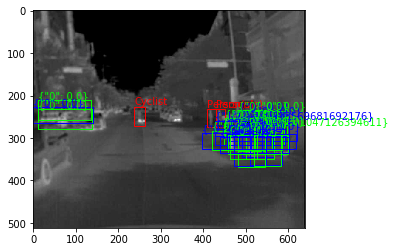

92.0 false positives (IOU = 0)
8.0 bad positives (0 < IOU < 0.5)
0.0 good positives (IOU >= 0.5)
Mean: 0.0018891469757732653


In [43]:
plot_iou(0, "first", False)


Test
6 prediction boxes made for 3 actual boxes in set01_V001_I00165


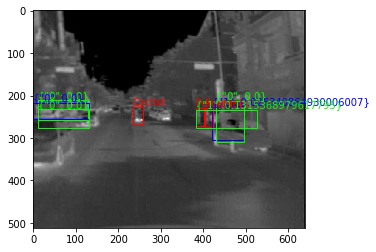

66.66666666666666 false positives (IOU = 0)
33.33333333333333 bad positives (0 < IOU < 0.5)
0.0 good positives (IOU >= 0.5)
Mean: 0.026146293815297584


In [61]:
plot_iou(train_i, "last", False)


Test
6 prediction boxes made for 3 actual boxes in set01_V001_I00165


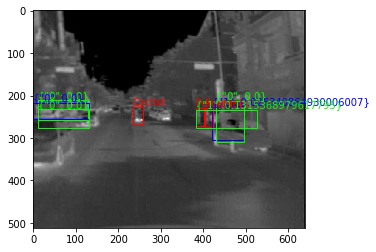

66.66666666666666 false positives (IOU = 0)
33.33333333333333 bad positives (0 < IOU < 0.5)
0.0 good positives (IOU >= 0.5)
Mean: 0.026146293815297584


In [63]:
plot_iou(test_i, "last", True)
